In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
exchange_rates_df  = pd.read_csv("Copy of Data - Sheet1.csv")

In [2]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes (currencies)
currencies = exchange_rates_df.columns[1:]
G.add_nodes_from(currencies)

# Add edges with exchange rates
for i, row in exchange_rates_df.iterrows():
    from_currency = row[0]
    for to_currency in currencies:
        exchange_rate = row[to_currency]
        # Add edge from 'to_currency' to 'from_currency' with exchange rate as weight
        G.add_edge(to_currency, from_currency, rate=exchange_rate)

G.number_of_nodes(), G.number_of_edges()

# Verify the structure of the graph
list(G.edges(data=True))[:10]  # Display first 10 edges for verification


[('USD', 'USD', {'rate': 1.0}),
 ('USD', 'EUR', {'rate': 0.94117}),
 ('USD', 'GBP', {'rate': 0.8193}),
 ('USD', 'CAD', {'rate': 1.3695}),
 ('USD', 'CHF', {'rate': 0.98281}),
 ('USD', 'JPY', {'rate': 149.885}),
 ('USD', 'CNH', {'rate': 7.31512}),
 ('USD', 'DKK', {'rate': 7.02205}),
 ('USD', 'HUF', {'rate': 358.93}),
 ('USD', 'MXN', {'rate': 18.1802})]

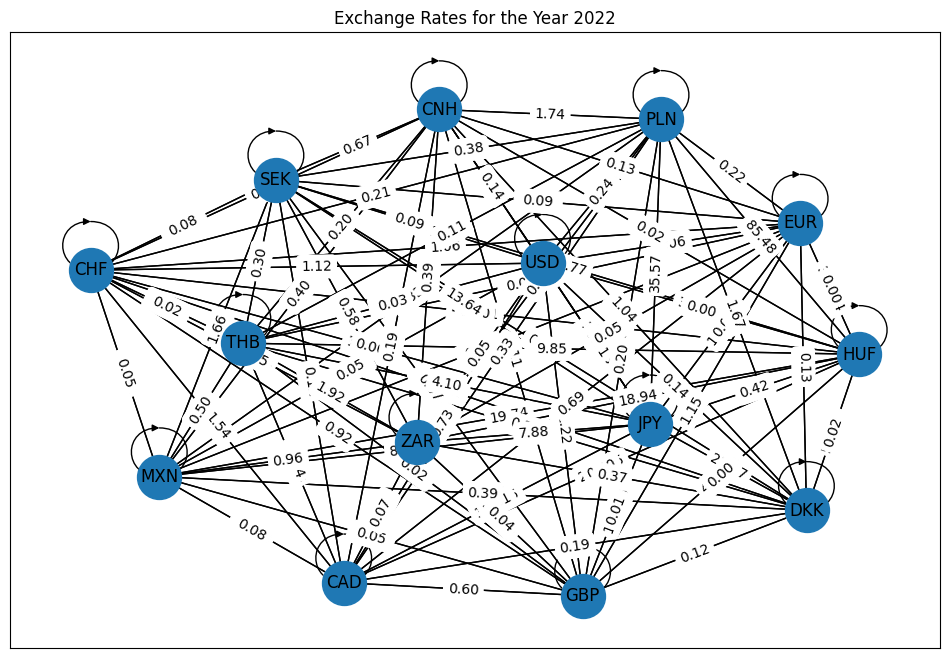

In [3]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=1000)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['rate']:.2f}" for u, v, d in G.edges(data=True)})
plt.title("Exchange Rates for the Year 2022")
plt.show()


'Arbitrage opportunity found:\nExchange THB to ZAR at rate 0.518040, New amount: 518.04\nExchange ZAR to SEK at rate 0.576430, New amount: 298.61\nExchange SEK to PLN at rate 0.382720, New amount: 114.29\nExchange PLN to MXN at rate 4.325890, New amount: 494.39\nExchange MXN to HUF at rate 19.736450, New amount: 9757.43\nExchange HUF to DKK at rate 0.019510, New amount: 190.37\nExchange DKK to CNH at rate 1.039740, New amount: 197.93\nExchange CNH to JPY at rate 20.449460, New amount: 4047.62\nExchange JPY to CHF at rate 0.055950, New amount: 226.46\nExchange CHF to THB at rate 40.851430, New amount: 9251.39\n'

In [60]:
def find_specific_arbitrage_opportunity_corrected(G, start_currency, start_amount):
    """
    Corrected function to find an arbitrage opportunity that starts and ends with a specified currency.

    Parameters:
    G (nx.DiGraph): The graph representing currencies and exchange rates.
    start_currency (str): The starting and ending currency code.
    start_amount (float): The amount in the starting currency.

    Returns:
    str: A description of the arbitrage opportunity or a message indicating none was found.
    """
    # Transform exchange rates to costs
    for u, v, d in G.edges(data=True):
        d['weight'] = -np.log(d['rate'])

    # Run the Bellman-Ford algorithm to find negative cycles
    try:
        # Using the bellman_ford_predecessor_and_distance function
        nx.bellman_ford_predecessor_and_distance(G, source=start_currency, weight='weight')
        return "No arbitrage opportunity found starting with " + start_currency
    except nx.NetworkXUnbounded:
        # Find a negative cycle
        for cycle in nx.simple_cycles(G):
            if start_currency in cycle:
                cycle_weight = sum(G[u][v]['weight'] for u, v in zip(cycle, cycle[1:] + [cycle[0]]))
                if cycle_weight < 0:
                    # Make sure the cycle starts and ends at start_currency
                    start_index = cycle.index(start_currency)
                    arbitrage_cycle = cycle[start_index:] + cycle[:start_index+1]

                    # Translate the negative cycle back into currency exchange steps
                    cycle_details = "Arbitrage opportunity found:\n"
                    amount = start_amount
                    for i in range(len(arbitrage_cycle) - 1):
                        from_currency = arbitrage_cycle[i]
                        to_currency = arbitrage_cycle[i + 1]
                        rate = G[from_currency][to_currency]['rate']
                        amount *= rate
                        cycle_details += f"Exchange {from_currency} to {to_currency} at rate {rate:.6f}, New amount: {amount:.2f}\n"
                    
                    return cycle_details

        return "No specific arbitrage opportunity found starting and ending with " + start_currency

# Example usage
find_specific_arbitrage_opportunity_corrected(G, 'JPY', 1000.0)


'Arbitrage opportunity found:\nExchange JPY to CHF at rate 0.055950, New amount: 55.95\nExchange CHF to THB at rate 40.851430, New amount: 2285.64\nExchange THB to ZAR at rate 0.518040, New amount: 1184.05\nExchange ZAR to SEK at rate 0.576430, New amount: 682.52\nExchange SEK to PLN at rate 0.382720, New amount: 261.22\nExchange PLN to MXN at rate 4.325890, New amount: 1129.99\nExchange MXN to HUF at rate 19.736450, New amount: 22301.95\nExchange HUF to DKK at rate 0.019510, New amount: 435.11\nExchange DKK to CNH at rate 1.039740, New amount: 452.40\nExchange CNH to JPY at rate 20.449460, New amount: 9251.39\n'

In [ ]:
def find_all_arbitrage_opportunities(G, start_currency, start_amount, max_cycles=50):
    """
    Finds all arbitrage opportunities starting with a specified currency and limited to a maximum number of cycles.

    Parameters:
    G (nx.DiGraph): The graph representing currencies and exchange rates.
    start_currency (str): The starting currency code.
    start_amount (float): The amount in the starting currency.
    max_cycles (int): The maximum number of cycles to consider for efficiency.

    Returns:
    list: A list of arbitrage opportunities, each represented as a sequence of exchanges and the final amount.
    """
    # Transform exchange rates to costs
    for u, v, d in G.edges(data=True):
        d['weight'] = -np.log(d['rate'])

    arbitrage_opportunities = []

    # Run the Bellman-Ford algorithm to find negative cycles
    try:
        nx.bellman_ford_predecessor_and_distance(G, source=start_currency, weight='weight')
        return "No arbitrage opportunity found starting with " + start_currency
    except nx.NetworkXUnbounded:
        cycle_count = 0
        for cycle in nx.simple_cycles(G):
            if cycle_count >= max_cycles:
                break

            if start_currency in cycle:
                cycle_weight = sum(G[u][v]['weight'] for u, v in zip(cycle, cycle[1:] + [cycle[0]]))
                if cycle_weight < 0:
                    # Make sure the cycle starts and ends at start_currency
                    start_index = cycle.index(start_currency)
                    arbitrage_cycle = cycle[start_index:] + cycle[:start_index+1]

                    # Translate the negative cycle back into currency exchange steps
                    cycle_details = []
                    amount = start_amount
                    for i in range(len(arbitrage_cycle) - 1):
                        from_currency = arbitrage_cycle[i]
                        to_currency = arbitrage_cycle[i + 1]
                        rate = G[from_currency][to_currency]['rate']
                        amount *= rate
                        cycle_details.append((from_currency, to_currency, rate, amount))

                    arbitrage_opportunities.append(cycle_details)
                    cycle_count += 1

        return arbitrage_opportunities

# Example usage
all_arbitrage_opportunities = find_all_arbitrage_opportunities(G, 'USD', 100.0)
all_arbitrage_opportunities[:3]  # Display first 3 arbitrage opportunities for brevity


C:\Users\sammy\AppData\Local\Temp\ipykernel_37748\598115020.py:16: RuntimeWarning: divide by zero encountered in log
  d['weight'] = -np.log(d['weight'])
C:\Users\sammy\AppData\Local\Temp\ipykernel_37748\598115020.py:16: RuntimeWarning: invalid value encountered in log
  d['weight'] = -np.log(d['weight'])


'No '

In [4]:
def find_all_arbitrage_opportunities(G, start_currency, start_amount, cycle_limit=100):
    """
    Finds all arbitrage opportunities for a given starting currency and amount,
    limited by a specified number of cycles for efficiency.

    Parameters:
    G (nx.DiGraph): The graph representing currencies and exchange rates.
    start_currency (str): The starting and ending currency code.
    start_amount (float): The amount in the starting currency.
    cycle_limit (int): The maximum number of cycles to check.

    Returns:
    list: A list of arbitrage opportunities, each represented as a dictionary.
    """
    # Transform exchange rates to costs
    for u, v, d in G.edges(data=True):
        d['weight'] = -np.log(d['rate'])

    # List to store arbitrage opportunities
    arbitrage_opportunities = []

    # Iterate through cycles, limited by cycle_limit
    for cycle in nx.simple_cycles(G):
        if len(arbitrage_opportunities) >= cycle_limit:
            break

        if start_currency in cycle:
            cycle_weight = sum(G[u][v]['weight'] for u, v in zip(cycle, cycle[1:] + [cycle[0]]))
            if cycle_weight < 0:
                # Make sure the cycle starts and ends at start_currency
                start_index = cycle.index(start_currency)
                arbitrage_cycle = cycle[start_index:] + cycle[:start_index+1]

                # Translate the negative cycle back into currency exchange steps
                steps = []
                amount = start_amount
                for i in range(len(arbitrage_cycle) - 1):
                    from_currency = arbitrage_cycle[i]
                    to_currency = arbitrage_cycle[i + 1]
                    rate = G[from_currency][to_currency]['rate']
                    amount *= rate
                    steps.append({'from': from_currency, 'to': to_currency, 'rate': rate, 'amount': amount})

                arbitrage_opportunities.append({
                    'starting_currency': start_currency,
                    'starting_amount': start_amount,
                    'final_amount': amount,
                    'steps': steps
                })

    return arbitrage_opportunities

# Find all arbitrage opportunities starting with USD and 1000.0
arbitrage_opportunities = find_all_arbitrage_opportunities(G, 'USD', 1000.0, cycle_limit=100)

# Identify the best opportunity
best_opportunity = max(arbitrage_opportunities, key=lambda x: x['final_amount']) if arbitrage_opportunities else None

best_opportunity


{'starting_currency': 'USD',
 'starting_amount': 1000.0,
 'final_amount': 9283.024758639966,
 'steps': [{'from': 'USD', 'to': 'JPY', 'rate': 149.885, 'amount': 149885.0},
  {'from': 'JPY', 'to': 'CHF', 'rate': 0.05595, 'amount': 8386.06575},
  {'from': 'CHF', 'to': 'EUR', 'rate': 1.05756, 'amount': 8868.76769457},
  {'from': 'EUR', 'to': 'ZAR', 'rate': 20.07499, 'amount': 178040.4227808158},
  {'from': 'ZAR', 'to': 'THB', 'rate': 1.91729, 'amount': 341355.1221934303},
  {'from': 'THB', 'to': 'SEK', 'rate': 0.29968, 'amount': 102297.3030189272},
  {'from': 'SEK', 'to': 'PLN', 'rate': 0.38272, 'amount': 39151.22381140382},
  {'from': 'PLN', 'to': 'MXN', 'rate': 4.32589, 'amount': 169363.88757351367},
  {'from': 'MXN', 'to': 'HUF', 'rate': 19.73645, 'amount': 3342641.898900274},
  {'from': 'HUF', 'to': 'DKK', 'rate': 0.01951, 'amount': 65214.94344754435},
  {'from': 'DKK', 'to': 'CNH', 'rate': 1.03974, 'amount': 67806.58530014977},
  {'from': 'CNH', 'to': 'GBP', 'rate': 0.11218, 'amount':

In [ ]:
def find_arbitrage_paths_dfs(graph, start_currency, initial_amount, max_cycles):
    """
    Find all arbitrage opportunities starting from a given currency with a constrained number of cycles.

    :param graph: The graph representing currency exchange rates (as log costs)
    :param start_currency: The starting currency
    :param initial_amount: The initial amount in the starting currency
    :param max_cycles: The maximum number of currency exchanges (cycles) to be considered
    :return: A list of arbitrage opportunities (path and final amount)
    """
    arbitrage_opportunities = []

    def dfs(current_currency, current_amount, path, depth):
        if depth > max_cycles:
            return
        if current_currency == start_currency and depth > 0:
            # Check if the current path results in arbitrage
            if current_amount > initial_amount:
                arbitrage_opportunities.append((path.copy(), current_amount))
            return
        for neighbor in graph.neighbors(current_currency):
            # Calculate the new amount after exchange
            exchange_rate = np.exp(-graph[current_currency][neighbor]['weight'])
            new_amount = current_amount * exchange_rate
            path.append(neighbor)
            dfs(neighbor, new_amount, path, depth + 1)
            path.pop()

    # Start DFS from the given starting currency
    dfs(start_currency, initial_amount, [start_currency], 0)

    return arbitrage_opportunities

# Example usage
start_currency = 'USD'
initial_amount = 1000  # Example denomination
max_cycles = 3  # Example constraint on number of cycles

arbitrage_opportunities = find_arbitrage_paths_dfs(G, start_currency, initial_amount, max_cycles)
arbitrage_opportunities[:5]  # Display the first 5 arbitrage opportunities for illustration


In [5]:
def find_arbitrage_opportunities_floyd_warshall(start_currency, denomination, max_cycles, graph):
    """
    Find all possible arbitrage opportunities starting from a given currency,
    with a constrained number of cycles, using the Floyd-Warshall Algorithm.
    
    :param start_currency: Starting currency for the arbitrage opportunity.
    :param denomination: The amount of money in the starting currency.
    :param max_cycles: Maximum number of cycles to consider for arbitrage.
    :param graph: The graph representing currencies and exchange rates.
    :return: A list of arbitrage opportunities.
    """
    # Convert graph nodes to a list for indexing
    nodes = list(graph.nodes())
    node_index = {node: i for i, node in enumerate(nodes)}

    # Run Floyd-Warshall Algorithm to get shortest path distances
    dist_matrix = nx.floyd_warshall_numpy(graph)

    # Look for negative cycles
    opportunities = []
    for i, start_node in enumerate(nodes):
        if start_node != start_currency:
            continue

        for j, end_node in enumerate(nodes):
            if i == j or dist_matrix[i][j] + dist_matrix[j][i] >= 0:
                continue

            # Found a potential negative cycle, reconstruct the cycle
            cycle = [start_node]
            k = j
            while nodes[k] != start_node:
                cycle.append(nodes[k])
                # Find the predecessor of k in the path from i to k
                for m in range(len(nodes)):
                    if dist_matrix[i][m] + graph[nodes[m]][nodes[k]]['weight'] == dist_matrix[i][k]:
                        k = m
                        break

            # Check if the cycle is within the max_cycles limit
            if len(cycle) <= max_cycles + 1:
                # Calculate potential profit
                profit = denomination
                for n in range(len(cycle) - 1):
                    profit *= np.exp(-graph[cycle[n]][cycle[n + 1]]['weight'])
                profit -= denomination  # Subtract the initial amount to get the profit

                opportunities.append({
                    'cycle': cycle,
                    'profit': profit
                })

    return opportunities

# Find arbitrage opportunities for a given starting currency, denomination, and max cycles
arbitrage_opportunities_fw = find_arbitrage_opportunities_floyd_warshall("USD", 1000, 20, G)
arbitrage_opportunities_fw
